In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
df=pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# EDA

In [56]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [57]:
df.shape

(545, 13)

In [58]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [59]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [60]:
df['furnishingstatus'].value_counts()

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

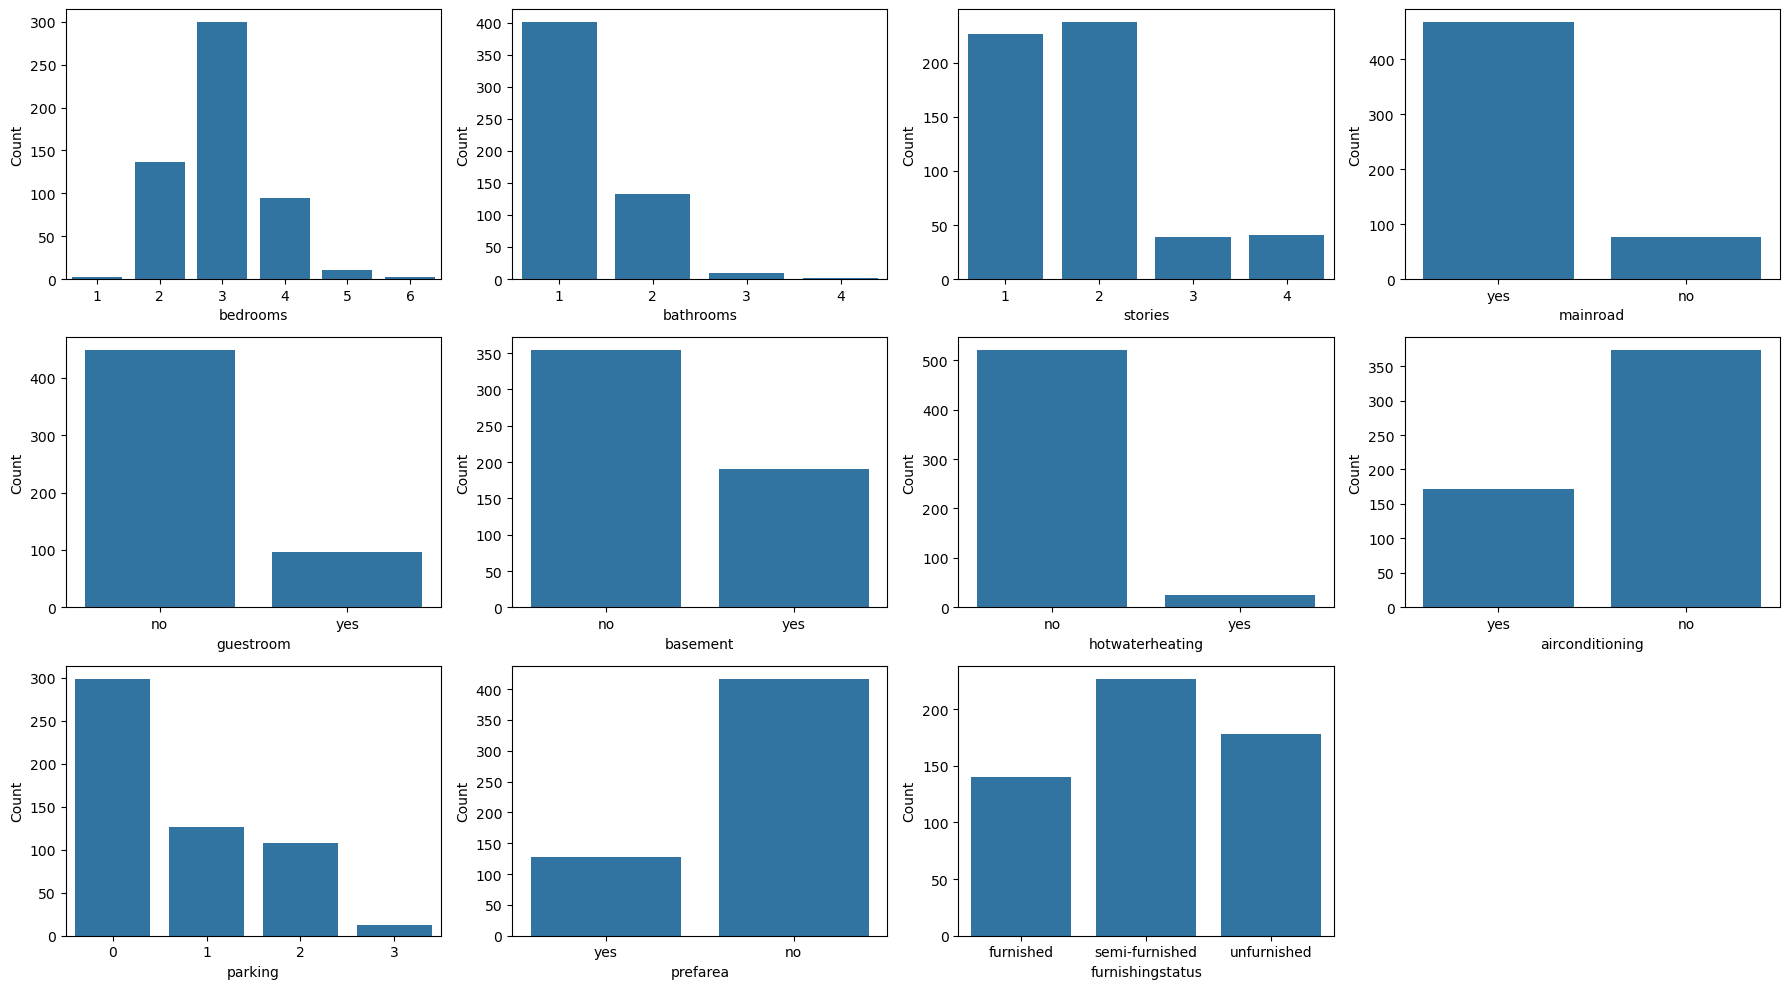

In [61]:
cols=['bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus']
plt.figure(figsize=(18,10))
plotnumber=1
for i in cols:
    plt.subplot(3,4,plotnumber)
    plotnumber+=1
    sns.countplot(data=df,x=i)
    plt.xlabel(i)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

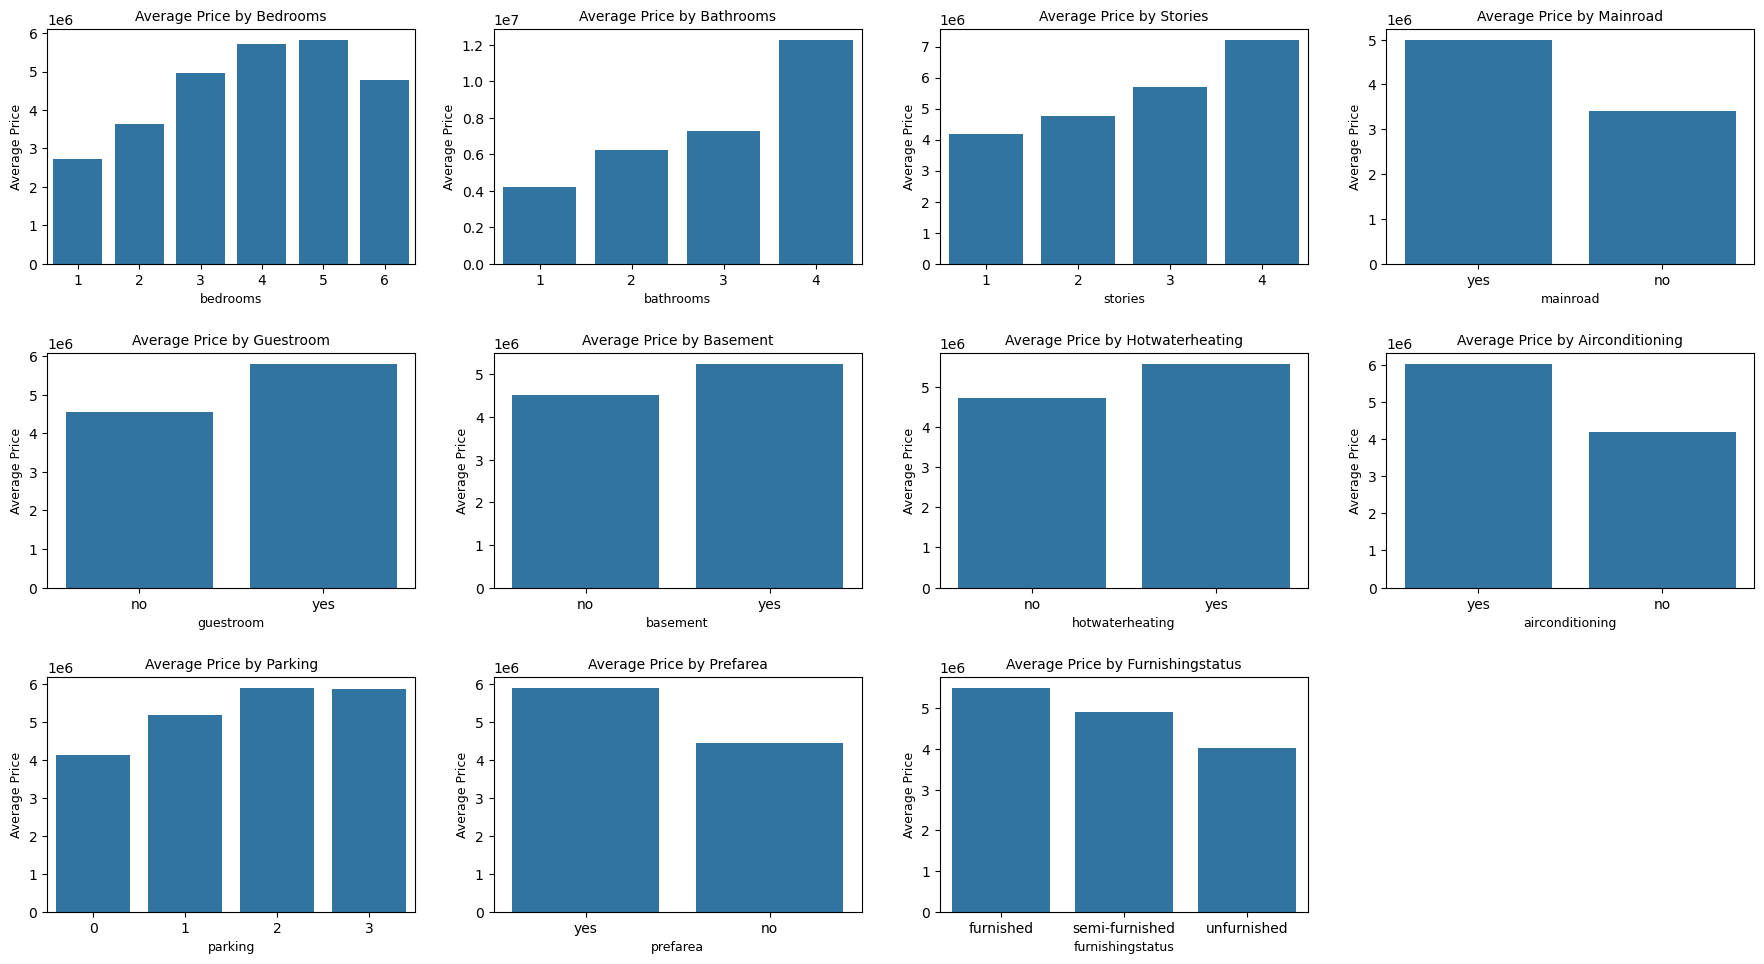

In [62]:
#how each feature affect the price
plt.figure(figsize=(18, 10))
plotnumber = 1
for i in cols:
    plt.subplot(3, 4, plotnumber)
    plotnumber += 1
    sns.barplot(data=df, x=i, y='price', estimator='mean',errorbar=None)
    plt.xlabel(i, fontsize=9)
    plt.ylabel('Average Price', fontsize=9)
    plt.title(f'Average Price by {i.capitalize()}', fontsize=10)
plt.tight_layout(pad=2.0)
plt.show()

In [63]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

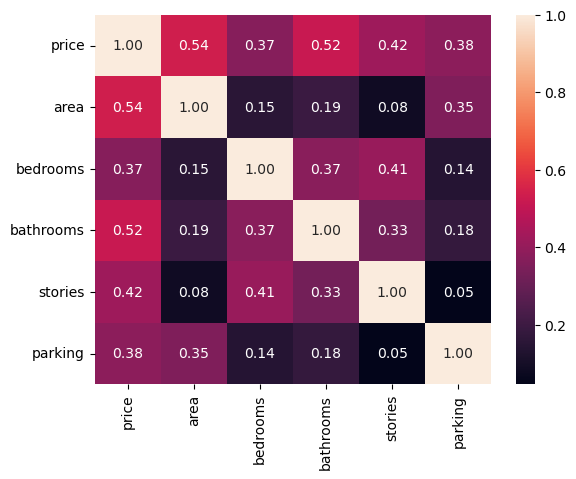

In [64]:
num=df.select_dtypes('int')
cor=num.corr()
sns.heatmap(cor,annot=True,fmt='.2f')
plt.show()

# Model fitting

In [65]:
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
cols=['mainroad','guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
X_train = pd.get_dummies(X_train, columns=cols,drop_first=True)
X_test=pd.get_dummies(X_test,columns=cols,drop_first=True)

In [67]:
#outliers
def outliers_boxplot(features,target):
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    sns.boxplot(y=features)
    plt.subplot(1,2,2)
    sns.boxplot(y=target)
    plt.show()

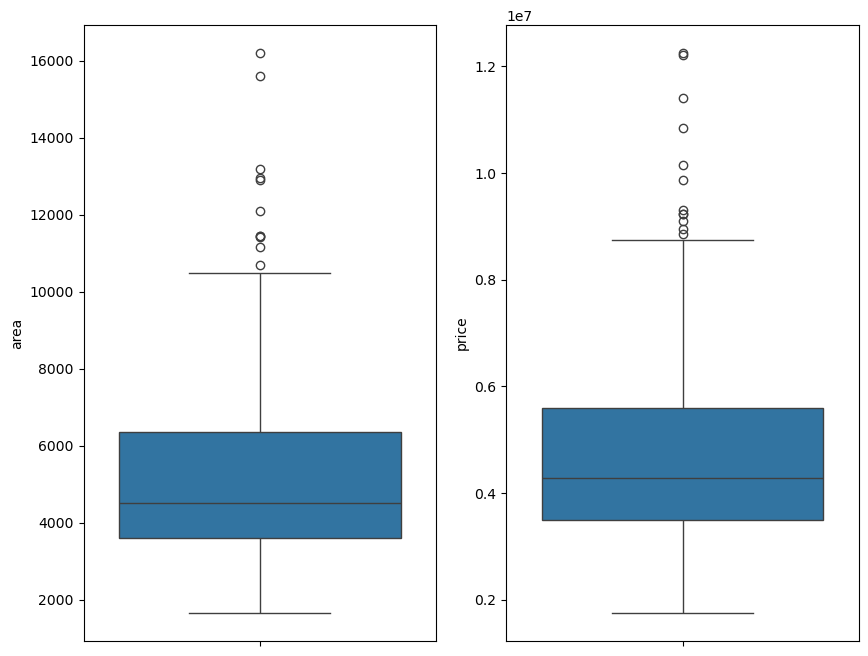

In [68]:
#train
outliers_boxplot(X_train['area'],y_train)

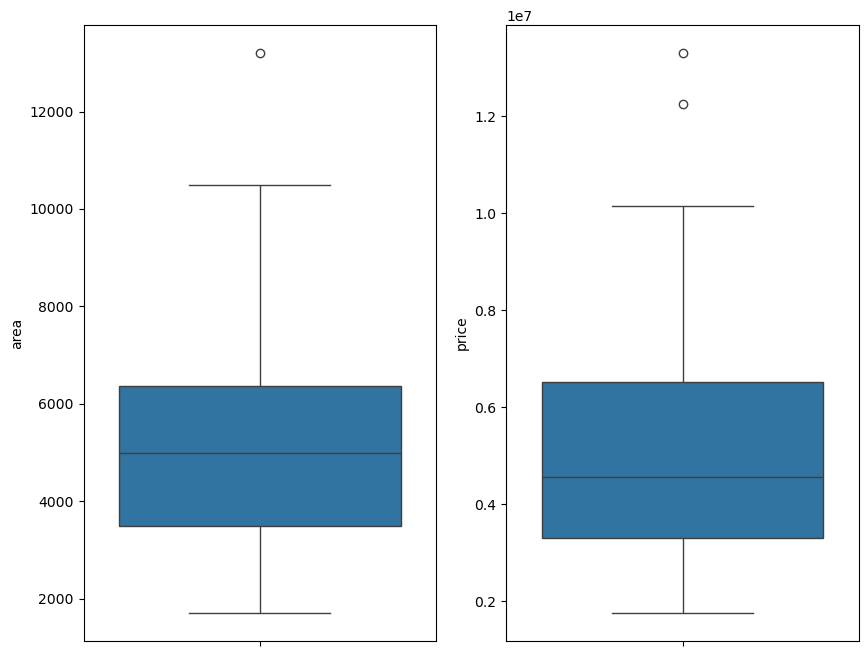

In [69]:
#test
outliers_boxplot(X_test['area'],y_test)

In [70]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()
feature_outliers = count_outliers(X_train['area'])
target_outliers = count_outliers(y_train)
feature_outliers_Test = count_outliers(X_test['area'])
target_outliers_test= count_outliers(y_test)
print('-----------Target---------------')
print(f" Outliers in area: {feature_outliers}")
print(f" Outliers in price: {target_outliers}")
print('-----------Test---------------')
print(f" Outliers in area: {feature_outliers_Test}")
print(f" Outliers in price: {target_outliers_test}")


-----------Target---------------
 Outliers in area: 11
 Outliers in price: 12
-----------Test---------------
 Outliers in area: 1
 Outliers in price: 2


In [71]:
print(X_train.shape)
print(X_test.shape)

(436, 13)
(109, 13)


In [72]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column]=np.clip(df[column], lower, upper)

In [73]:
remove_outliers_iqr(X_test,'area')
remove_outliers_iqr(X_train,'area')
y_train = pd.DataFrame(y_train, columns=['price'])
y_test = pd.DataFrame(y_test, columns=['price'])
#remove_outliers_iqr(y_test,'price')
remove_outliers_iqr(y_train,'price')
y_train = pd.Series(y_train['price'])
y_test = pd.Series(y_test['price'])

In [74]:
def distribution_plots(features,target):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    sns.histplot(features['area'], kde=True)
    plt.title(f'Distribution of area')
    plt.subplot(1,2,2)
    sns.histplot(target, kde=True)
    plt.title(f'Distribution of price')
    plt.tight_layout()
    plt.show()

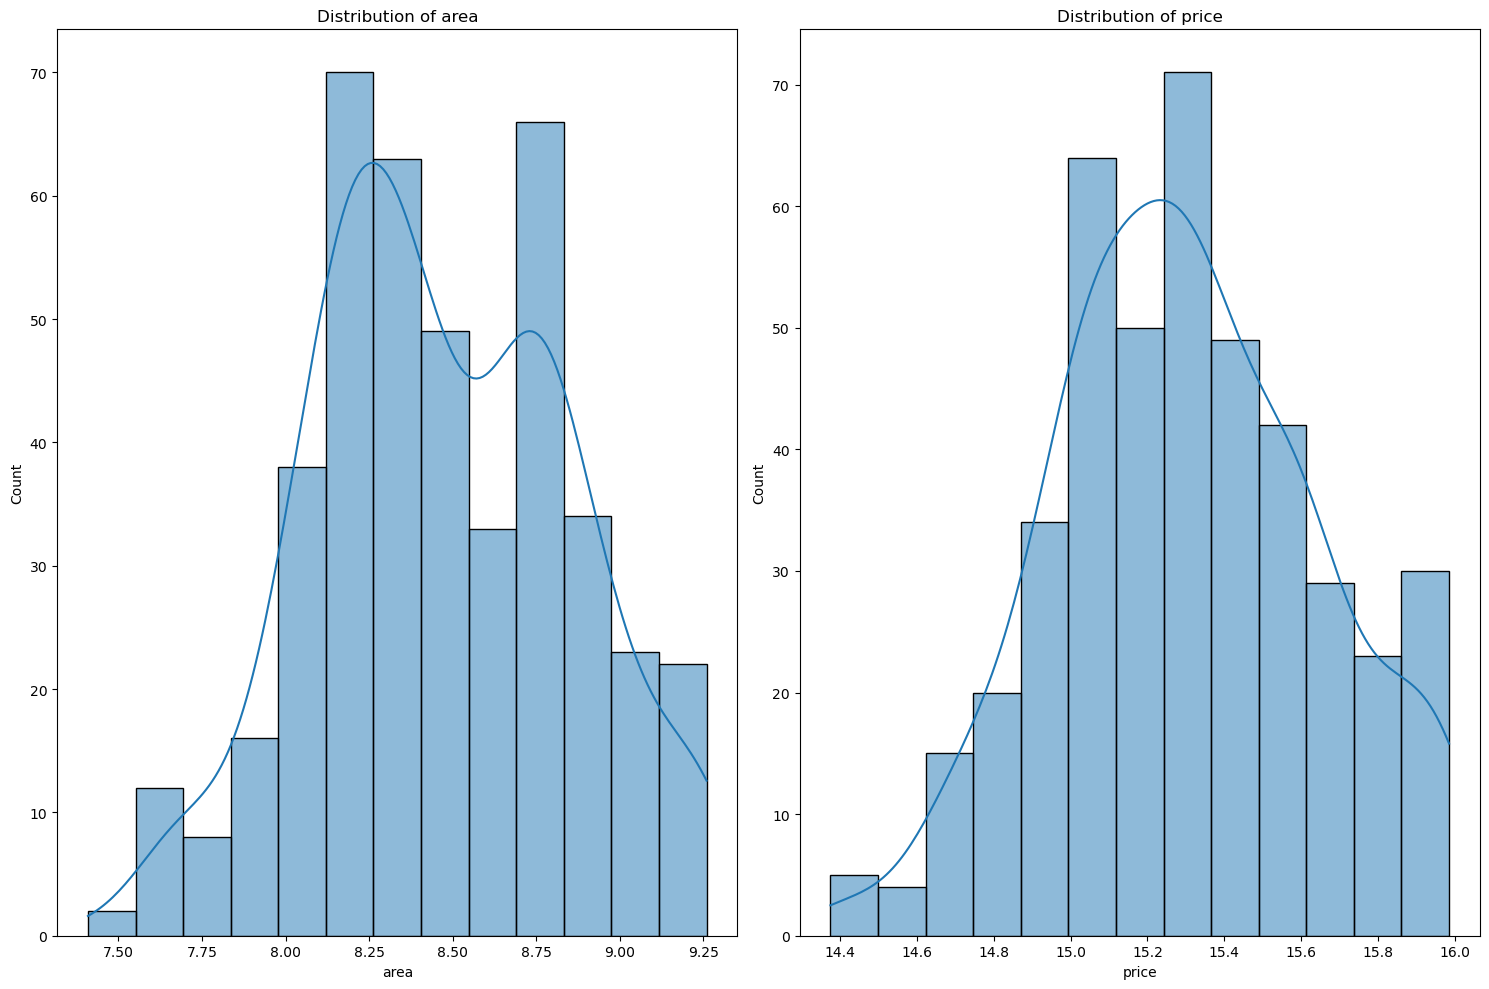

In [87]:
#Train data
distribution_plots(X_train,y_train)

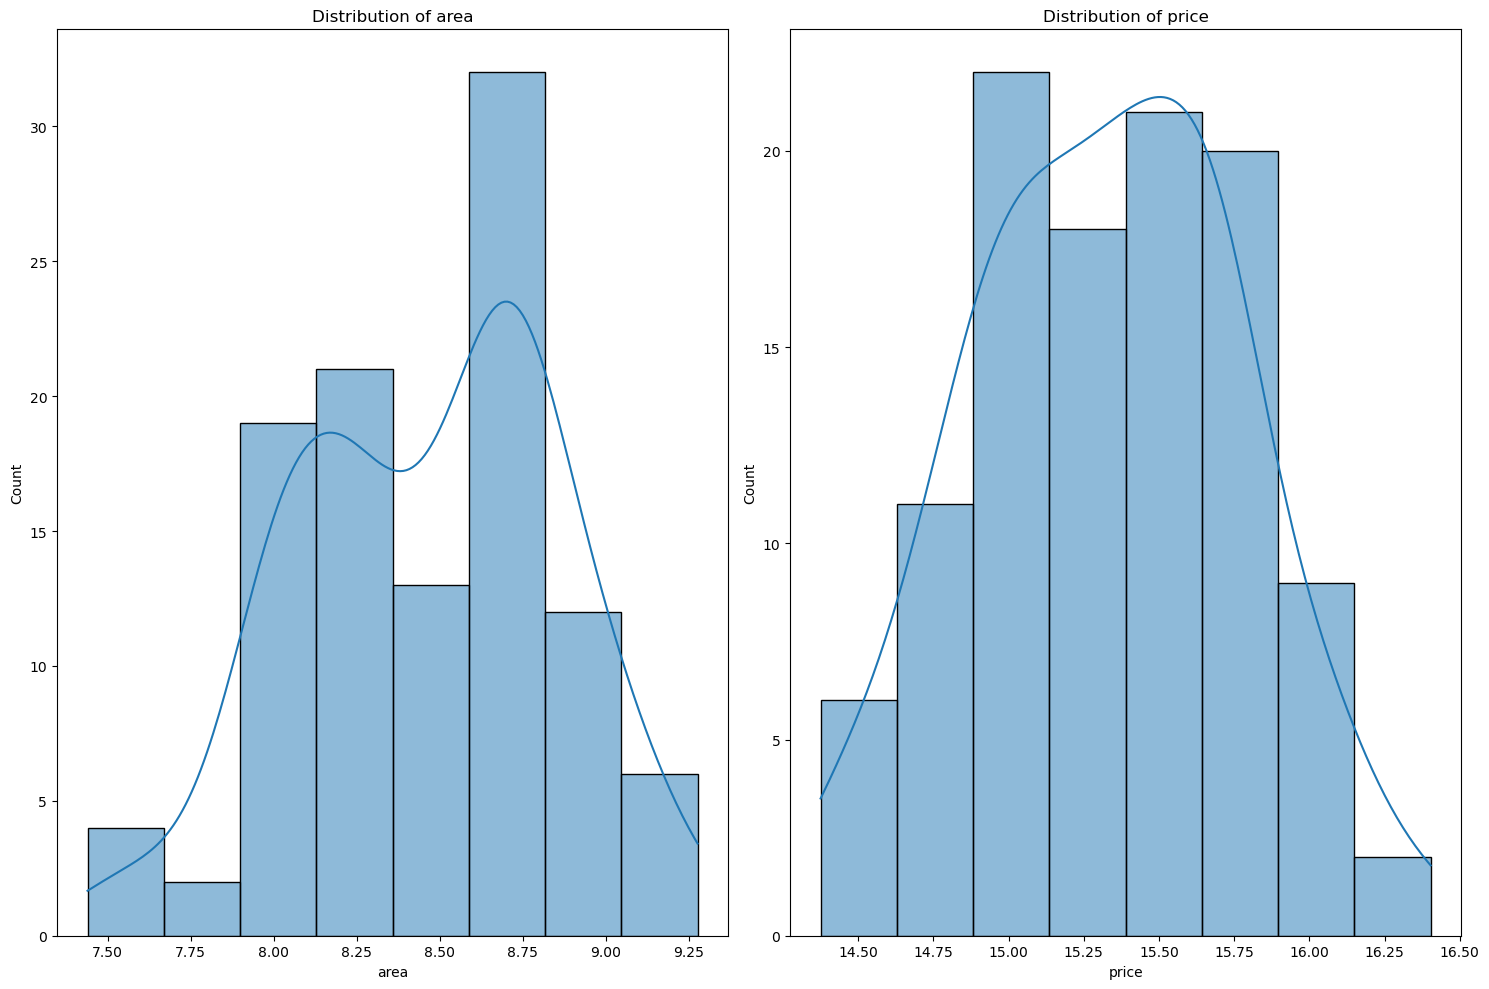

In [88]:
#Test data
distribution_plots(X_test,y_test)

In [77]:
print(X_train['area'].skew())
print(X_test['area'].skew())
print(pd.Series(y_train).skew())
print(pd.Series(y_test).skew())

0.8664049315604329
0.56612646775743
0.8073434815771899
1.0841081804696355


In [78]:
X_train['area']=np.log1p(X_train['area'])
X_test['area']=np.log1p(X_test['area'])
y_train=np.log1p(y_train)
y_test=np.log1p(y_test)

In [79]:
from sklearn.linear_model import LinearRegression
linear=LinearRegression()
linear.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [80]:
y_test_pred=linear.predict(X_test)

In [81]:
y_test.shape

(109,)

In [82]:
y_train_pred=linear.predict(X_train)

In [83]:
y_test_pred.shape

(109,)

In [84]:
from sklearn.metrics import r2_score,mean_absolute_error
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
n_train = X_train.shape[0]  # number of training samples
p = X_train.shape[1]        # number of features
residuals_train=y_train-y_train_pred
residuals_test=y_test-y_test_pred
n_test = X_test.shape[0]    # number of test samples

In [85]:
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
print(f"Train R²: {r2_train:.4f}, Adjusted R²: {adjusted_r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}, Adjusted R²: {adjusted_r2_test:.4f}")#Drop is not too high so not overfited
print(f"Train MAE: {mean_absolute_error(y_train,y_train_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test,y_test_pred):.4f}")

Train R²: 0.7105, Adjusted R²: 0.7016
Test R²: 0.6758, Adjusted R²: 0.6314
Train MAE: 0.1427
Test MAE: 0.2000


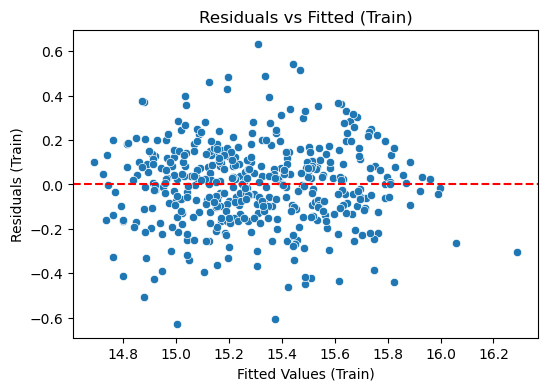

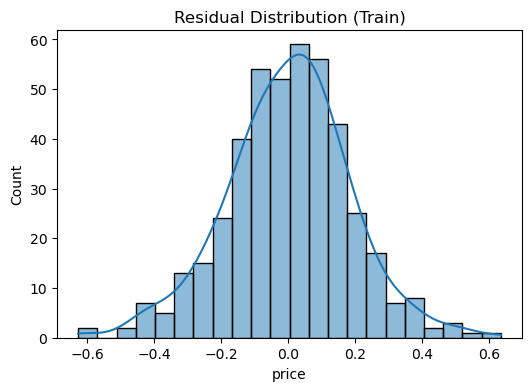

In [86]:
#Residual Analysis
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Train)")
plt.ylabel("Residuals (Train)")
plt.title("Residuals vs Fitted (Train)")
plt.show()
plt.figure(figsize=(6,4))
sns.histplot(residuals_train, kde=True)
plt.title("Residual Distribution (Train)")
plt.show()
